In [4]:
!pip install umap-learn

In [2]:
import networkx as nx # https://networkx.org/documentation/stable/tutorial.html
import numpy as np
import random
import argparse
import pickle
import torch
from gensim.models import Word2Vec # https://radimrehurek.com/gensim/
import pandas as pd
from matplotlib import pyplot as plt
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [5]:
edges_path = '/kaggle/input/facebook-large-pagepage-network-data-set/facebook_large/musae_facebook_edges.csv'
targets_path = '/kaggle/input/facebook-large-pagepage-network-data-set/facebook_large/musae_facebook_target.csv'
features_path =  '/kaggle/input/facebook-large-pagepage-network-data-set/facebook_large/musae_facebook_features.json'

#Read in edges
edges = pd.read_csv(edges_path)

#Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.id


# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)

max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 22470/22470 [00:00<00:00, 44497.54it/s]


In [6]:
# Read in Graph
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

In [15]:
A = nx.adjacency_matrix(graph)
print(A.todense())

[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
# Reference : https://github.com/Manu-Fraile/Network-Representation-Learning/blob/master/DeepWalk/main.py
# https://github.com/rlagywns0213/2021_Summer_Internship/blob/main/Graph%20Neural%20Network/RandomWalk/Deepwalk/train.py
# sg parameter if 1 skip gram for Word2Vec https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# hs parameter if 1 hierarchical softmax
class DeepWalk(torch.nn.Module):
    def __init__(self, G, w = 10, d = 128, gamma = 30, t = 6):
        super(DeepWalk, self).__init__()
        self.G = G  
        self.w = w    #window size
        self.d = d    # embedding size
        self.gamma = gamma    # walks per vertex
        self.t = t  # walk length
        self.embedding = None
        self.wvmodel = None

    def randomWalk(self, st_v): 
        one_walk = []
        current_node = st_v 
        one_walk.append(str(st_v))
        for j in range(self.t - 1): # self.t = walk_length 
            neighbors = list(self.G.edges([st_v])) 
            if (len(neighbors) > 0): 
                random_edge = random.choice(neighbors) 
            if (random_edge[0] == current_node): 
                current_node = random_edge[1] 
            else : 
                current_node = random_edge[0] 
            one_walk.append(str(current_node))
        return one_walk

    def fit(self): 
        walks = []
        nodes = list(self.G.nodes())
        print('starting', len(self.G.nodes))
        for i in tqdm(range(self.gamma)): 
            random.shuffle(nodes)
            for node in nodes: 
                walks.append(self.randomWalk(node)) 
        self.wvmodel = Word2Vec(walks, vector_size=self.d, window=self.w, sg=1, hs=1)
        self.embedding = self.wvmodel.wv.vectors

    def get_vectors(self): 
        return self.embedding

    def get_wvmodel(self): 
        return self.wvmodel.wv

In [32]:
w = DeepWalk(graph, 5, 64, 5, 10)

In [33]:
w.fit()

starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


In [34]:
similar_to = '22196'
wvmodel = w.get_wvmodel()
targets.loc[[int(similar_to)] + [int(v[0]) for v in wvmodel.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
22196,22196,205251616243022,American Express,company
12287,12287,168312979854782,American Express,company
351,351,411991108813820,American Express,company
6293,6293,137583909626199,American Express,company
16984,16984,117495044948602,American Express אמריקן אקספרס,company


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

def test_randomforest(wvmodel, title): 
    # Get targets 
    y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

    # Get corresponding embeddings
    X_dw = []
    for i in y.index:
        X_dw.append(wvmodel.__getitem__(str(i)))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2, random_state=42) 

    # Train RF model
    print('title: ', title)
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate
    print(f1_score(y_test, y_pred, average='micro'))

In [40]:
test_randomforest(wvmodel, 'dimension 10')

title:  dimension 10
0.8157543391188251
[[0.91441441 0.05255255 0.02627628 0.00675676]
 [0.07518248 0.87664234 0.04671533 0.00145985]
 [0.09314587 0.08172232 0.82513181 0.        ]
 [0.38073394 0.08103976 0.06727829 0.47094801]]


In [41]:
def test_dimensions(dim_list): 
    for i in dim_list:
        print('testing dimension.. ' + str(i))
        w = DeepWalk(graph, 5, i, 5, 10)
        w.fit()
        wvmodel = w.get_wvmodel()
        print(wvmodel.vectors.shape)
        test_randomforest(wvmodel, 'dimension ' + str(i))

In [42]:
test_dimensions([1])

testing dimension.. 1
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


(22470, 1)
title:  dimension 1
0.30774365821094796
[[0.29954955 0.3033033  0.24399399 0.15315315]
 [0.27518248 0.38759124 0.20145985 0.13576642]
 [0.28558875 0.25659051 0.30404218 0.15377856]
 [0.28440367 0.2706422  0.28134557 0.16360856]]


In [46]:
test_dimensions([4])

testing dimension.. 4
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


(22470, 4)
title:  dimension 4
0.5965732087227414
[[0.6493994  0.15165165 0.10585586 0.09309309]
 [0.13722628 0.70437956 0.12627737 0.03211679]
 [0.18980668 0.16432337 0.58611599 0.05975395]
 [0.45412844 0.13761468 0.12691131 0.28134557]]


In [60]:
test_dimensions([32])

testing dimension.. 32
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


(22470, 32)
title:  dimension 32
0.787716955941255
[[0.89339339 0.05780781 0.03903904 0.00975976]
 [0.10364964 0.83211679 0.0620438  0.00218978]
 [0.1168717  0.09226714 0.78734622 0.00351494]
 [0.37614679 0.06727829 0.0764526  0.48012232]]


In [43]:
test_dimensions([2, 8, 16])

testing dimension.. 2
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


(22470, 2)
title:  dimension 2
0.3700489541611037
[[0.34309309 0.31906907 0.23498498 0.10285285]
 [0.25620438 0.5        0.18321168 0.06058394]
 [0.27943761 0.25043937 0.37258348 0.09753954]
 [0.32721713 0.25993884 0.26452599 0.14831804]]
testing dimension.. 8
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


(22470, 8)
title:  dimension 8
0.7501112594570538
[[0.82582583 0.08033033 0.05555556 0.03828829]
 [0.11532847 0.81021898 0.06277372 0.01167883]
 [0.12038664 0.12741652 0.73550088 0.01669596]
 [0.31039755 0.09785933 0.09633028 0.49541284]]
testing dimension.. 16
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


(22470, 16)
title:  dimension 16
0.783266577659101
[[0.86711712 0.07282282 0.04504505 0.01501502]
 [0.08978102 0.83357664 0.07080292 0.00583942]
 [0.1142355  0.0887522  0.78734622 0.00966608]
 [0.33792049 0.07033639 0.09174312 0.5       ]]


In [44]:
test_dimensions([64, 128, 256])

testing dimension.. 64
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


(22470, 64)
title:  dimension 64
0.8046283934134403
[[8.98648649e-01 7.28228228e-02 2.62762763e-02 2.25225225e-03]
 [7.00729927e-02 8.78832117e-01 4.96350365e-02 1.45985401e-03]
 [1.00175747e-01 8.61159930e-02 8.12829525e-01 8.78734622e-04]
 [3.76146789e-01 6.72782875e-02 1.13149847e-01 4.43425076e-01]]
testing dimension.. 128
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


(22470, 128)
title:  dimension 128
0.8139741878059635
[[8.99399399e-01 6.45645646e-02 3.00300300e-02 6.00600601e-03]
 [6.64233577e-02 8.90510949e-01 4.23357664e-02 7.29927007e-04]
 [6.94200351e-02 9.92970123e-02 8.31282953e-01 0.00000000e+00]
 [3.70030581e-01 9.78593272e-02 8.25688073e-02 4.49541284e-01]]
testing dimension.. 256
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


(22470, 256)
title:  dimension 256
0.8088562527814864
[[8.99399399e-01 6.38138138e-02 3.30330330e-02 3.75375375e-03]
 [5.47445255e-02 9.00000000e-01 4.52554745e-02 0.00000000e+00]
 [7.55711775e-02 1.13356766e-01 8.10193322e-01 8.78734622e-04]
 [3.91437309e-01 9.48012232e-02 8.25688073e-02 4.31192661e-01]]


In [45]:
test_dimensions([512])

testing dimension.. 512
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


(22470, 512)
title:  dimension 512
0.8066310636404095
[[0.89564565 0.07657658 0.02477477 0.003003  ]
 [0.05985401 0.89343066 0.04671533 0.        ]
 [0.06766257 0.11247803 0.8198594  0.        ]
 [0.39296636 0.09938838 0.08715596 0.4204893 ]]


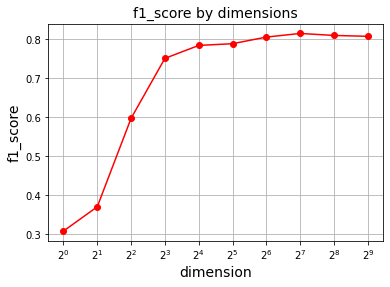

In [62]:
0.30774365821094796

data = {'dimension': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
        'f1_score': [
            0.30774365821094796, # 1
            0.3700489541611037, # 2
            0.5965732087227414, # 4
            0.7501112594570538, # 8
            0.783266577659101, # 16
            0.787716955941255, 
            0.8046283934134403, # 64
            0.8139741878059635, # 128
            0.8088562527814864, # 256
            0.8066310636404095 # 512
        ]
       }
  
df = pd.DataFrame(data)
  
plt.plot(df['dimension'], df['f1_score'], color='red', marker='o')
plt.title('f1_score by dimensions', fontsize=14)
plt.xlabel('dimension', fontsize=14)
plt.ylabel('f1_score', fontsize=14)
plt.xscale('log', base=2)
plt.xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512])
plt.grid(True)
plt.show()

In [67]:
from time import time, sleep

def test_wlength(walk_length_list): 
    for i in walk_length_list:
        start = time()
        print('testing walk length.. ' + str(i))
        w = DeepWalk(graph, 5, 8, 5, i) # dimension 8로 고정 
        w.fit()
        wvmodel = w.get_wvmodel()
        end = time() 
        print('model build time elapsed: ', end-start)
        print(wvmodel.vectors.shape)
        test_randomforest(wvmodel, 'walk length.. ' + str(i))

In [68]:
test_wlength([5, 10, 30, 60, 90])

testing walk length.. 5
starting 22470


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


(22470, 8)
title:  walk length.. 5
0.5594125500667557
testing walk length.. 10
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


(22470, 8)
title:  walk length.. 10
0.7627948375611927
testing walk length.. 30
starting 22470


100%|██████████| 5/5 [01:00<00:00, 12.13s/it]


(22470, 8)
title:  walk length.. 30
0.84334668446818
testing walk length.. 60
starting 22470


100%|██████████| 5/5 [02:01<00:00, 24.30s/it]


(22470, 8)
title:  walk length.. 60
0.8724966622162884
testing walk length.. 90
starting 22470


100%|██████████| 5/5 [03:03<00:00, 36.68s/it]


(22470, 8)
title:  walk length.. 90
0.8800623052959502


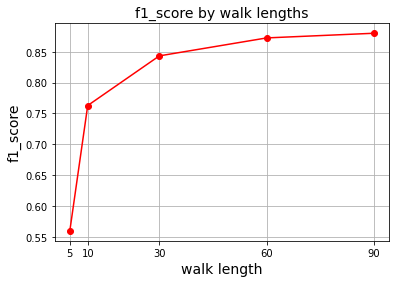

In [71]:
data = {'walk_length': [5, 10, 30, 60, 90],
        'f1_score': [
            0.5594125500667557, #5 
            0.7627948375611927, #10
            0.84334668446818, #30 
            0.8724966622162884, #60 
            0.8800623052959502, #90
        ]
       }
  
df = pd.DataFrame(data)
  
plt.plot(df['walk_length'], df['f1_score'], color='red', marker='o')
plt.title('f1_score by walk lengths', fontsize=14)
plt.xlabel('walk length', fontsize=14)
plt.ylabel('f1_score', fontsize=14)
plt.xticks(data['walk_length'])
plt.grid(True)
plt.show()

In [72]:
from time import time, sleep

def test_winsize(win_size_list): 
    for i in win_size_list:
        start = time()
        w = DeepWalk(graph, i, 8, 5, 10) # dimension 8 walk length 10로 고정
        w.fit()
        wvmodel = w.get_wvmodel()
        end = time() 
        print(str(i) + 'model build time elapsed: ', end-start)
        print(wvmodel.vectors.shape)
        test_randomforest(wvmodel, 'window size.. ' + str(i))
test_winsize([2, 4, 5, 10, 15])

starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


2model build time elapsed:  35.16078996658325
(22470, 8)
title:  window size.. 2
0.69826435246996
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


4model build time elapsed:  42.050923347473145
(22470, 8)
title:  window size.. 4
0.7409879839786382
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


5model build time elapsed:  44.31469941139221
(22470, 8)
title:  window size.. 5
0.7387627948375612
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


10model build time elapsed:  50.220094442367554
(22470, 8)
title:  window size.. 10
0.7839341344014241
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


15model build time elapsed:  56.14787793159485
(22470, 8)
title:  window size.. 15
0.7874944370271473


In [73]:
test_winsize([30, 60])

starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


30model build time elapsed:  57.81586837768555
(22470, 8)
title:  window size.. 30
0.8052959501557633
starting 22470


100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


60model build time elapsed:  59.186299562454224
(22470, 8)
title:  window size.. 60
0.8052959501557633


In [74]:
test_winsize([90, 120])

starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


90model build time elapsed:  59.146644592285156
(22470, 8)
title:  window size.. 90
0.810636404094348
starting 22470


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


120model build time elapsed:  58.542484521865845
(22470, 8)
title:  window size.. 120
0.7999554962171784


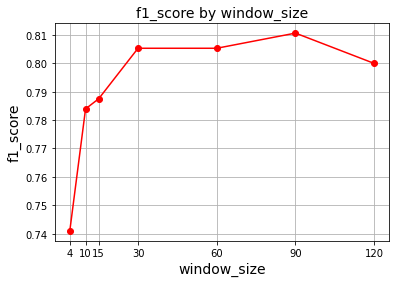

In [3]:
data = {'window_size': [4, 10, 15, 30, 60, 90, 120],
        'f1_score': [
            0.7409879839786382, #4 
            0.7839341344014241, #10 
            0.7874944370271473, #15 
            0.8052959501557633, #30 
            0.8052959501557633, #60 
            0.810636404094348, #90
            0.7999554962171784, #120
            
        ]
       }
  
df = pd.DataFrame(data)
  
plt.plot(df['window_size'], df['f1_score'], color='red', marker='o')
plt.title('f1_score by window_size', fontsize=14)
plt.xlabel('window_size', fontsize=14)
plt.ylabel('f1_score', fontsize=14)
plt.xticks(data['window_size'])
plt.grid(True)
plt.show()